In [ ]:
from datetime import datetime
import random 
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, fbeta_score, classification_report
from sklearn.metrics import make_scorer 
import matplotlib.pyplot as plt
import gensim.downloader as api
import nltk
from nltk.tokenize import word_tokenize
from nltk import pos_tag
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from google.colab import drive
drive.mount('/content/gdrive')
dir_name = "/content/gdrive/MyDrive/Thesis/"

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
def con2bin(label):
  if label in ['Psoriasis', 'Chicken pox', 'Impetigo', 'Acne']:
    return 1
  return 0

In [ ]:
def get_raw_data(dir_name):
    #  load data
    data = pd.read_csv('{}Symptom2Disease.csv'.format(dir_name), encoding = 'latin-1', usecols=['text', 'label'])
    data['label'] =  data['label'].apply(con2bin)
    return data

raw_data = get_raw_data(dir_name + 'datasets/')
raw_data

,label,text
0,1,I have been experiencing a skin rash on my arm...
1,1,"My skin has been peeling, especially on my kne..."
2,1,I have been experiencing joint pain in my fing...
3,1,"There is a silver like dusting on my skin, esp..."
4,1,"My nails have small dents or pits in them, and..."
...,...,...
1195,0,I'm shaking and trembling all over. I've lost ...
1196,0,"Particularly in the crevices of my skin, I hav..."
1197,0,I regularly experience these intense urges and...
1198,0,"I have trouble breathing, especially outside. ..."


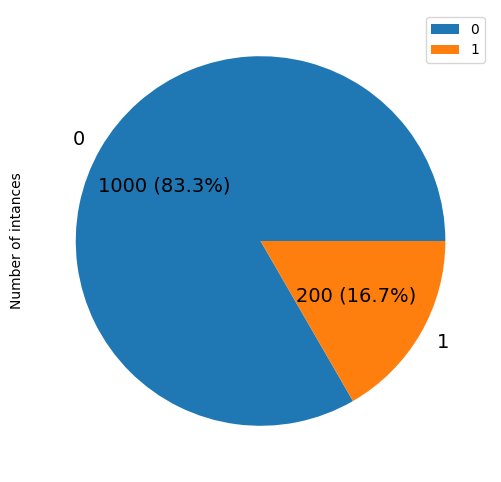

In [ ]:
def get_dataset_statistics(data):
    dataset_statistics = {'Number of intances': [data['label'].value_counts()[0], data['label'].value_counts()[1]]}
    df = pd.DataFrame(dataset_statistics, index=['0', '1'])
    df.plot(kind='pie', y='Number of intances', figsize=(6, 6), fontsize=14,
            autopct=lambda v: '{:.0f} ({:.1f}%)'.format(v / 100 * data['label'].count(), v))
    
get_dataset_statistics(raw_data)

In [ ]:
raw_data['text'].is_unique

False

In [ ]:
raw_data.drop_duplicates( inplace=True)
raw_data['text'].is_unique

True

In [ ]:
raw_data

,label,text
0,1,I have been experiencing a skin rash on my arm...
1,1,"My skin has been peeling, especially on my kne..."
2,1,I have been experiencing joint pain in my fing...
3,1,"There is a silver like dusting on my skin, esp..."
4,1,"My nails have small dents or pits in them, and..."
...,...,...
1195,0,I'm shaking and trembling all over. I've lost ...
1196,0,"Particularly in the crevices of my skin, I hav..."
1197,0,I regularly experience these intense urges and...
1198,0,"I have trouble breathing, especially outside. ..."


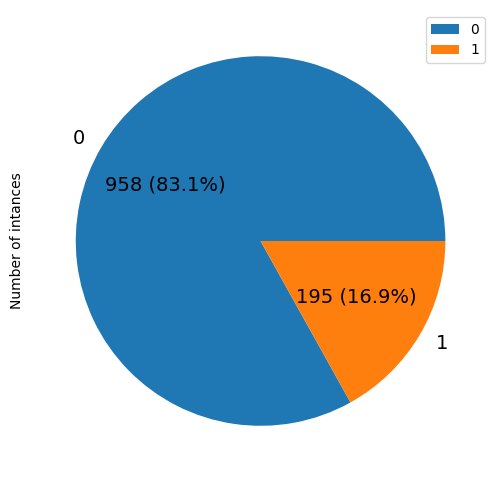

In [ ]:
get_dataset_statistics(raw_data)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(raw_data['text'].to_numpy(), raw_data['label'].to_numpy(), stratify=raw_data['label'].to_numpy(), test_size=0.2, random_state=24)

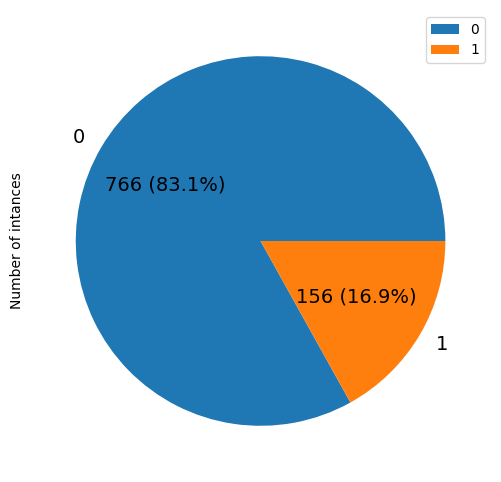

In [ ]:
get_dataset_statistics(pd.DataFrame({'label': y_train}))

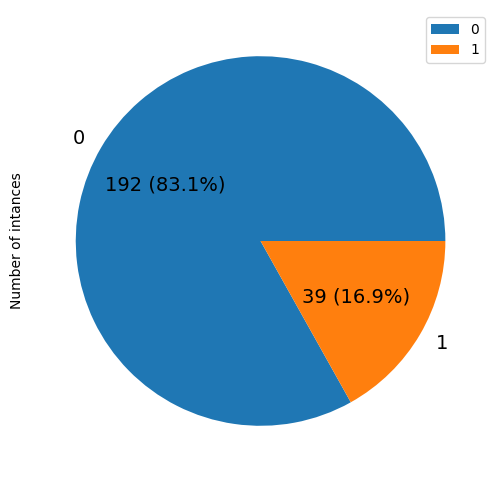

In [ ]:
get_dataset_statistics(pd.DataFrame({'label': y_test}))

In [ ]:
train_data = pd.DataFrame({'text': X_train, 'label': y_train})
train_data

,text,label
0,I am quite queasy and dizzy when I have a temp...,0
1,I've been experiencing muscular weakness and s...,0
2,"Over the last week, the rash on my face has go...",1
3,I have a frequent need to urinate and often ha...,0
4,I am feeling quite weak. I'm having a lot of s...,0
...,...,...
917,Sometimes my skin starts to flake off from my ...,0
918,My skin has a horrible rash that is absolutely...,1
919,I occasionally have burning in my upper abdome...,0
920,I lose weight unintentionally and find it chal...,0


In [ ]:
test_data = pd.DataFrame({'text': X_test, 'label': y_test})
test_data

,text,label
0,My cheeks and nose are covered with red sores....,1
1,"My vision is blurry, and it feels like it's ge...",0
2,I have noticed a sudden peeling of skin at dif...,1
3,I've been suffering from severe constipation l...,0
4,The sores around my nose are now surrounded by...,1
...,...,...
226,I have been feeling nauseous and have a consta...,0
227,I have a sour acidic taste in my mouth. I have...,0
228,I routinely experience heartburn and indigesti...,0
229,The veins on my calves have become very promin...,0


# Text Preprocessing 

In [ ]:
import requests
stopwords_list = requests.get("https://github.com/stopwords-iso/stopwords-en/blob/master/stopwords-en.txt").content
stopwords = set(stopwords_list.decode().splitlines())

In [ ]:
import string
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
sklearn_stopwords = ENGLISH_STOP_WORDS

stop_words = set(stopwords.words('english'))
stop_words.update(sklearn_stopwords)

def text_preprocessing(raw_text):
  text_words = raw_text.translate(str.maketrans('', '', string.punctuation))
  msg_tokens = word_tokenize(text_words.lower())
  filtered_text = [token for token in msg_tokens if not token in stop_words]
  return " ".join(filtered_text)

In [ ]:
train_data = train_data[['text', 'label']].copy()

train_data['text'] = train_data['text'].apply(text_preprocessing)

train_data.drop_duplicates(inplace=True)

train_data

,text,label
0,quite queasy dizzy temperature brain completel...,0
1,ive experiencing muscular weakness stiffness n...,0
2,week rash face gotten severe painful sores beg...,1
3,frequent need urinate uncontrollable urges fee...,0
4,feeling quite weak im lot stomach discomfort c...,0
...,...,...
917,skin starts flake rashes im prone sick result ...,0
918,skin horrible rash absolutely nonheritable bla...,1
919,occasionally burning upper abdomen day night h...,0
920,lose weight unintentionally challenging acquir...,0


In [ ]:
test_data = test_data[['text', 'label']].copy()

test_data['text'] = test_data['text'].apply(text_preprocessing)

test_data.drop_duplicates(inplace=True)

test_data

,text,label
0,cheeks nose covered red sores ive observed ras...,1
1,vision blurry feels like getting worse time fe...,0
2,noticed sudden peeling skin different parts bo...,1
3,ive suffering severe constipation lately restr...,0
4,sores nose surrounded red inflamed skin rash c...,1
...,...,...
226,feeling nauseous constant urge vomit strong pa...,0
227,sour acidic taste mouth frequent belching burp...,0
228,routinely experience heartburn indigestion par...,0
229,veins calves prominent causing discomfort stan...,0


# Feature Extraction

In [ ]:
word2vec_model = api.load("word2vec-google-news-300")

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [ ]:
def get_text_vec(sent):
  vector = np.mean(np.array([word2vec_model[token] for token in word_tokenize(sent) if token in word2vec_model.key_to_index]), axis=0)
  if np.all(np.isnan(vector)) :
    return np.zeros(300)
  return vector

In [ ]:
ori_X_train = np.stack(np.array([get_text_vec(text) for text in train_data['text'].values]))

In [ ]:
ori_X_train.shape

(919, 300)

In [ ]:
X_test = np.stack(np.array([get_text_vec(text) for text in test_data['text'].values]))

In [ ]:
X_test.shape

(231, 300)

In [ ]:
ori_y_train = train_data['label'].values

In [ ]:
ori_y_train.shape

(919,)

In [ ]:
y_test = test_data['label'].values

In [ ]:
y_test.shape

(231,)

# Model selection, training and evaluation

In [ ]:
def f_beta_score(y_true, y_pred):
  return fbeta_score(y_true, y_pred, beta=2)

f2_score = make_scorer(f_beta_score, greater_is_better=True)

In [ ]:
from datetime import datetime

def save_cross_validation(results, file_name):
  results_to_save = pd.DataFrame(columns=['Accuracy', 'Recall', 'Precision', 'F1 Score', 'F2 Score'])
  for i in range(0, 10):
    results_to_save.loc[i] = [
      results['split{}_test_Accuracy'.format(i)][0],
      results['split{}_test_Recall'.format(i)][0],
      results['split{}_test_Precision'.format(i)][0],
      results['split{}_test_F1'.format(i)][0],
      results['split{}_test_F2'.format(i)][0]
    ]
  results_to_save.to_csv('{}Results/{}_{}.csv'.format(dir_name+'experiments/Skin Diseases/', file_name, datetime.now().strftime("%m%d%H%M")))

In [ ]:
def train_model(classifier, param_grid, model_name, train_texts, train_labels, test_texts, test_labels, evaluation_metrics, to_print=True, to_save=False, file_name=None):
    """
    train email classification model.
    """

    # apply grid search to find best model hyper parameters
    grid_search = GridSearchCV(classifier, param_grid, cv=10, scoring={'Accuracy': make_scorer(accuracy_score),
                                                                       'F1': make_scorer(f1_score),
                                                                       'F2': f2_score,
                                                                       'Recall': make_scorer(recall_score),
                                                                       'Precision': make_scorer(precision_score)
                                                                       }, refit='F1', n_jobs=-1)
    grid_search.fit(train_texts, train_labels)
    model = grid_search.best_estimator_

    if to_save:
      ConfusionMatrixDisplay(save_cross_validation(grid_search.cv_results_, file_name))
      plt.show()

    # train and test accuracy.
    test_accuracy = model.score(test_texts, test_labels)
    train_accuracy = model.score(train_texts, train_labels)

    # compute F1 score for model evaluation.
    y_pred = model.predict(test_texts)

    recall = recall_score(test_labels, y_pred)
    precision = precision_score(test_labels, y_pred)
    f1score = f1_score(test_labels, y_pred)
    f2score = fbeta_score(y_test, y_pred, beta=2)

    if to_print:
        print("train accuracy = " + str(train_accuracy))
        print("test accuracy = " + str(test_accuracy))
        print("Recall = {}".format(recall))
        print("Precision = {}".format(precision))
        print("F1 score = {}".format(f1score))
        print("F2 score = {}".format(f2score))
        print(classification_report(test_labels, y_pred))


        # plot confusion matrix
        cm = confusion_matrix(test_labels, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])

        disp.plot(cmap=plt.cm.Blues)
        plt.show()

        # print best model hyper parameters.
        print(grid_search.best_params_)

    evaluation_metrics.loc[model_name, 'Recall'] = recall
    evaluation_metrics.loc[model_name, 'Precision'] = precision
    evaluation_metrics.loc[model_name, 'F1 score'] = f1score
    evaluation_metrics.loc[model_name, 'F2 score'] = f2score

    return f1score, f2score


def train(model_id, train_texts, train_labels, test_texts, test_labels, evaluation_metrics, to_print=True, to_save=False, file_name=None):
    
    if model_id == 1:
        # Random forest Classification model.
        forest_clf = RandomForestClassifier(random_state=42, n_jobs=-1)
        forest_param_grid = [{'n_estimators': [50, 75, 100, 150, 200], 'max_features': [8, 9, 10], 'min_samples_split': [25, 30], 'criterion': ['gini','entropy'], 'max_depth': [4, 5]}]
        return train_model(forest_clf, forest_param_grid, 'RandomForest', train_texts, train_labels, test_texts, test_labels, evaluation_metrics, to_print, to_save, file_name)

    if model_id == 2:
        # Support Vector Machine Model.
        svc_clf = SVC(random_state=42)
        svc_param_grid = [{'kernel': ['rbf', 'poly'], 'degree': [2, 3 , 4, 5]}]

        return train_model(svc_clf, svc_param_grid, 'SVM', train_texts, train_labels, test_texts, test_labels, evaluation_metrics, to_print, to_save, file_name)

In [ ]:
evaluation_metrics_orginal = pd.DataFrame(columns = ['Recall', 'Precision', 'F1 score', 'F2 score'])

#Random Forest

train accuracy = 0.9488574537540805
test accuracy = 0.9090909090909091
Recall = 0.48717948717948717
Precision = 0.95
F1 score = 0.6440677966101694
F2 score = 0.5397727272727272
              precision    recall  f1-score   support

           0       0.91      0.99      0.95       192
           1       0.95      0.49      0.64        39

    accuracy                           0.91       231
   macro avg       0.93      0.74      0.80       231
weighted avg       0.91      0.91      0.90       231



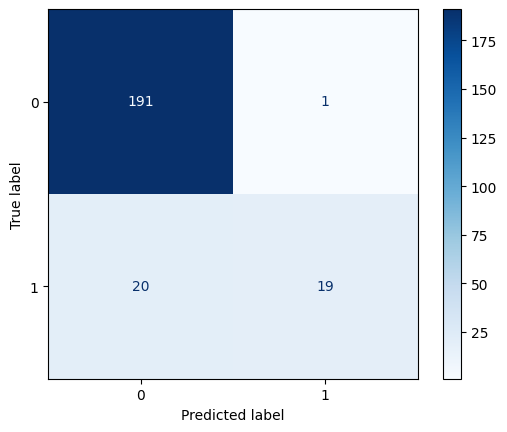

{'criterion': 'entropy', 'max_depth': 5, 'max_features': 10, 'min_samples_split': 25, 'n_estimators': 100}


(0.6440677966101694, 0.5397727272727272)

In [ ]:
train(1, ori_X_train, ori_y_train, X_test, y_test, evaluation_metrics_orginal, to_save=True, file_name='OD_RF')

#SVM

train accuracy = 0.9793253536452666
test accuracy = 0.9523809523809523
Recall = 0.7692307692307693
Precision = 0.9375
F1 score = 0.8450704225352113
F2 score = 0.7978723404255319
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       192
           1       0.94      0.77      0.85        39

    accuracy                           0.95       231
   macro avg       0.95      0.88      0.91       231
weighted avg       0.95      0.95      0.95       231



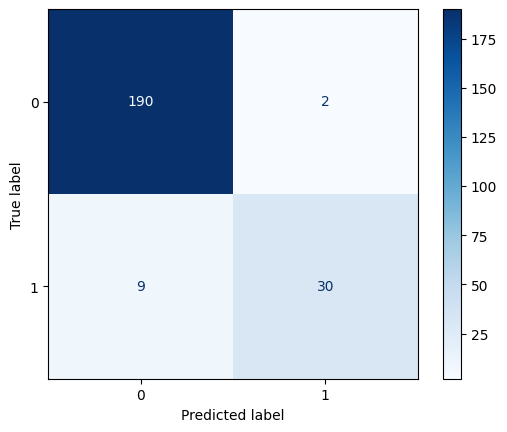

{'degree': 2, 'kernel': 'poly'}


(0.8450704225352113, 0.7978723404255319)

In [ ]:
train(2, ori_X_train, ori_y_train, X_test, y_test, evaluation_metrics_orginal, to_save=True, file_name='OD_SVM')

In [ ]:
evaluation_metrics_orginal

#BiLSTM

In [ ]:
import random
import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras import layers
from sklearn.metrics import ConfusionMatrixDisplay
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import L1L2
from sklearn.model_selection import StratifiedKFold

In [ ]:
text_words_lengths = [len(raw_data.loc[i]['text'].split()) for i in raw_data.index ]
total_length = np.sum(text_words_lengths)
text_words_mean = int(np.mean(text_words_lengths))

In [ ]:
total_length

35313

In [ ]:
text_words_mean

30

In [ ]:
def create_blstm_model(sent_length, words_mean, train_texts):

  text_vec = layers.TextVectorization( 
    max_tokens=sent_length,
    standardize='lower_and_strip_punctuation',
    output_mode='int',
    output_sequence_length=words_mean
  )

  text_vec.adapt(train_texts)

  embedding_layer = layers.Embedding(
    input_dim=sent_length,
    output_dim=128,
    embeddings_initializer='uniform',
    input_length=words_mean
  )

  input_layer = layers.Input(shape=(1,), dtype=tf.string) 

  vec_layer = text_vec(input_layer)
  embedding_layer_model = embedding_layer(vec_layer) 

  bi_lstm = layers.Bidirectional(layers.LSTM(64, activation='tanh', return_sequences=True, kernel_regularizer = L1L2(l1=0.01, l2=0.0)))(embedding_layer_model) 

  flatten = layers.Flatten()(bi_lstm) 
  dropout = layers.Dropout(.1)(flatten) 

  x = layers.Dense(32, activation='relu')(dropout) 

  output_layer = layers.Dense(1, activation='sigmoid')(x) 

  blstm_model = keras.Model(input_layer, output_layer) 

  blstm_model.compile(optimizer=keras.optimizers.Adam(),
                loss=keras.losses.BinaryCrossentropy(),
                metrics=['accuracy'])  
  
  return blstm_model

# Cross Validation

In [ ]:
def cv_blstm(sent_length, words_mean):

  kf = StratifiedKFold(10, shuffle=True, random_state=42) 
  cv_metrics = pd.DataFrame(columns = ['Recall', 'Precision', 'F1 score', 'F2 score'])

  fold = 0

  X = train_data['text'].values
  Y = train_data['label'].values

  for train, val in kf.split(X, Y):  
  
    print(f"Fold {fold}")

    train_texts = X[train]
    train_labels = Y[train]
    test_texts = X[val]
    test_labels = Y[val]

    blstm_model = create_blstm_model(sent_length, words_mean, train_texts)

    history = blstm_model.fit(train_texts,
                              train_labels,
                              epochs=10,
                              batch_size=16,
                              validation_data=(test_texts, test_labels))

    blstm_model.evaluate(test_texts, test_labels)
    y_pred = np.round(blstm_model.predict(test_texts))

    f1_sc = f1_score(test_labels, y_pred)
    f2score = fbeta_score(test_labels, y_pred, beta=2, average='binary')

    cv_metrics.loc[fold, 'Recall'] = recall_score(test_labels, y_pred)
    cv_metrics.loc[fold, 'Precision'] = precision_score(test_labels, y_pred)
    cv_metrics.loc[fold, 'F1 score'] = f1_sc
    cv_metrics.loc[fold, 'F2 score'] = f2score
    
    fold += 1

  return cv_metrics

In [ ]:
cv_results = cv_blstm(total_length, text_words_mean)

Fold 0
Epoch 1/10
52/52 [==============================] - 9s 99ms/step - loss: 27.2007 - accuracy: 0.8464 - val_loss: 14.5124 - val_accuracy: 0.9348
Epoch 2/10
52/52 [==============================] - 2s 39ms/step - loss: 7.0802 - accuracy: 0.9698 - val_loss: 2.0173 - val_accuracy: 0.9239
Epoch 3/10
52/52 [==============================] - 1s 24ms/step - loss: 0.5704 - accuracy: 0.9879 - val_loss: 0.2739 - val_accuracy: 0.9783
Epoch 4/10
52/52 [==============================] - 1s 25ms/step - loss: 0.1713 - accuracy: 0.9976 - val_loss: 0.2608 - val_accuracy: 0.9674
Epoch 5/10
52/52 [==============================] - 1s 20ms/step - loss: 0.1388 - accuracy: 0.9988 - val_loss: 0.1879 - val_accuracy: 0.9783
Epoch 6/10
52/52 [==============================] - 1s 14ms/step - loss: 0.2880 - accuracy: 0.9964 - val_loss: 0.5096 - val_accuracy: 0.9783
Epoch 7/10
52/52 [==============================] - 1s 17ms/step - loss: 0.2818 - accuracy: 0.9988 - val_loss: 0.2166 - val_accuracy: 0.9674
Epoc

3/3 [==============================] - 1s 5ms/step
Fold 3
Epoch 1/10
52/52 [==============================] - 10s 115ms/step - loss: 27.1700 - accuracy: 0.8295 - val_loss: 14.4203 - val_accuracy: 0.9348
Epoch 2/10
52/52 [==============================] - 2s 31ms/step - loss: 6.9692 - accuracy: 0.9686 - val_loss: 1.6123 - val_accuracy: 1.0000
Epoch 3/10
52/52 [==============================] - 1s 17ms/step - loss: 0.5346 - accuracy: 0.9891 - val_loss: 0.2695 - val_accuracy: 0.9891
Epoch 4/10
52/52 [==============================] - 1s 25ms/step - loss: 0.1605 - accuracy: 0.9976 - val_loss: 0.3603 - val_accuracy: 0.9457
Epoch 5/10
52/52 [==============================] - 1s 14ms/step - loss: 0.2219 - accuracy: 0.9903 - val_loss: 0.1766 - val_accuracy: 0.9891
Epoch 6/10
52/52 [==============================] - 1s 19ms/step - loss: 0.1153 - accuracy: 1.0000 - val_loss: 0.1050 - val_accuracy: 0.9891
Epoch 7/10
52/52 [==============================] - 1s 11ms/step - loss: 0.1344 - accuracy: 

3/3 [==============================] - 1s 5ms/step
Fold 4
Epoch 1/10
52/52 [==============================] - 10s 103ms/step - loss: 27.2023 - accuracy: 0.8247 - val_loss: 14.4689 - val_accuracy: 0.8696
Epoch 2/10
52/52 [==============================] - 1s 28ms/step - loss: 7.0035 - accuracy: 0.9686 - val_loss: 1.6617 - val_accuracy: 0.9565
Epoch 3/10
52/52 [==============================] - 1s 24ms/step - loss: 0.5784 - accuracy: 0.9879 - val_loss: 0.4864 - val_accuracy: 0.9348
Epoch 4/10
52/52 [==============================] - 1s 25ms/step - loss: 0.1939 - accuracy: 0.9952 - val_loss: 0.1472 - val_accuracy: 0.9891
Epoch 5/10
52/52 [==============================] - 1s 15ms/step - loss: 0.1861 - accuracy: 0.9952 - val_loss: 0.2570 - val_accuracy: 0.9783
Epoch 6/10
52/52 [==============================] - 0s 8ms/step - loss: 0.1368 - accuracy: 0.9988 - val_loss: 0.1450 - val_accuracy: 1.0000
Epoch 7/10
52/52 [==============================] - 1s 14ms/step - loss: 0.2391 - accuracy: 0

In [ ]:
cv_results

,Recall,Precision,F1 score,F2 score
0,0.866667,0.928571,0.896552,0.878378
1,0.933333,0.777778,0.848485,0.897436
2,1.0,0.882353,0.9375,0.974026
3,1.0,0.9375,0.967742,0.986842
4,0.866667,1.0,0.928571,0.890411
5,1.0,1.0,1.0,1.0
6,0.8125,1.0,0.896552,0.844156
7,1.0,0.666667,0.8,0.909091
8,0.875,1.0,0.933333,0.897436
9,1.0,0.882353,0.9375,0.974026


In [ ]:
cv_results.mean()

Recall       0.935417
Precision    0.907522
F1 score     0.914623
F2 score     0.925180
dtype: float64

In [ ]:
X_train = train_data['text'].values

In [ ]:
X_train.shape

(919,)

In [ ]:
y_train = train_data['label'].values.reshape(-1, 1)

In [ ]:
y_train.shape

(919, 1)

In [ ]:
X_test = test_data['text'].values.reshape(-1, 1)

In [ ]:
y_test = test_data['label'].values

In [ ]:
def train_blstm(sent_length, words_mean, train_texts, train_labels):

  blstm_model = create_blstm_model(sent_length, words_mean, train_texts)
  
  history = blstm_model.fit(train_texts,
                            train_labels,
                            epochs=10,
                            batch_size=16,
                            validation_data=(X_test, y_test))
  
  blstm_model.evaluate(X_test, y_test)
  y_pred = np.round(blstm_model.predict(X_test))

  f1_sc = f1_score(y_test, y_pred)
  f2score = fbeta_score(y_test, y_pred, beta=2, average='binary')


  print("test accuracy = " + str(accuracy_score(y_test, y_pred)))
  print("Recall = {}".format(recall_score(y_test, y_pred)))
  print("Precision = {}".format(precision_score(y_test, y_pred)))
  print("F1 score = {}".format(f1_sc))
  print("F2 score = {}".format(f2score))
  print(classification_report(y_test, y_pred))
  
  cm = confusion_matrix(y_test, y_pred)

  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])

  disp.plot(cmap=plt.cm.Blues)
  plt.show()

  return f1_sc

Epoch 1/10
58/58 [==============================] - 9s 95ms/step - loss: 25.7697 - accuracy: 0.8498 - val_loss: 12.2629 - val_accuracy: 0.9004
Epoch 2/10
58/58 [==============================] - 2s 43ms/step - loss: 5.1975 - accuracy: 0.9652 - val_loss: 0.7978 - val_accuracy: 0.9610
Epoch 3/10
58/58 [==============================] - 1s 23ms/step - loss: 0.3393 - accuracy: 0.9880 - val_loss: 0.2975 - val_accuracy: 0.9784
Epoch 4/10
58/58 [==============================] - 1s 21ms/step - loss: 0.1985 - accuracy: 0.9924 - val_loss: 0.2868 - val_accuracy: 0.9740
Epoch 5/10
58/58 [==============================] - 1s 14ms/step - loss: 0.1474 - accuracy: 0.9967 - val_loss: 0.2333 - val_accuracy: 0.9654
Epoch 6/10
58/58 [==============================] - 1s 16ms/step - loss: 0.1319 - accuracy: 0.9978 - val_loss: 0.1944 - val_accuracy: 0.9784
Epoch 7/10
58/58 [==============================] - 0s 8ms/step - loss: 0.1951 - accuracy: 0.9913 - val_loss: 0.3267 - val_accuracy: 0.9784
Epoch 8/10
5

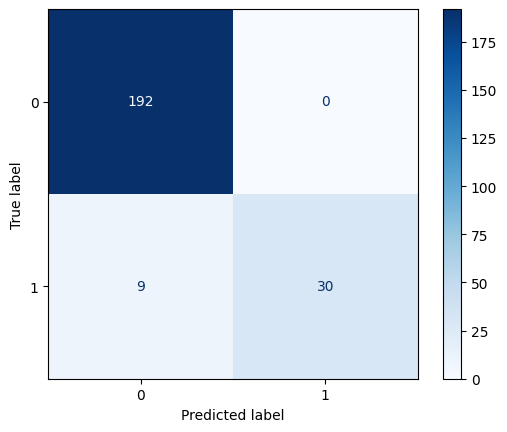

0.8695652173913044

In [ ]:
train_blstm(total_length, text_words_mean, X_train, y_train)

Epoch 1/10
58/58 [==============================] - 9s 90ms/step - loss: 25.9056 - accuracy: 0.8455 - val_loss: 12.3721 - val_accuracy: 0.8788
Epoch 2/10
58/58 [==============================] - 2s 38ms/step - loss: 5.2545 - accuracy: 0.9695 - val_loss: 0.7751 - val_accuracy: 0.9827
Epoch 3/10
58/58 [==============================] - 1s 21ms/step - loss: 0.3027 - accuracy: 0.9956 - val_loss: 0.1914 - val_accuracy: 0.9784
Epoch 4/10
58/58 [==============================] - 1s 20ms/step - loss: 0.5153 - accuracy: 0.9859 - val_loss: 0.4812 - val_accuracy: 0.9784
Epoch 5/10
58/58 [==============================] - 1s 18ms/step - loss: 0.2538 - accuracy: 0.9978 - val_loss: 0.2685 - val_accuracy: 0.9697
Epoch 6/10
58/58 [==============================] - 1s 13ms/step - loss: 0.1508 - accuracy: 0.9956 - val_loss: 1.1778 - val_accuracy: 0.9307
Epoch 7/10
58/58 [==============================] - 1s 13ms/step - loss: 0.2445 - accuracy: 0.9956 - val_loss: 0.2763 - val_accuracy: 0.9524
Epoch 8/10


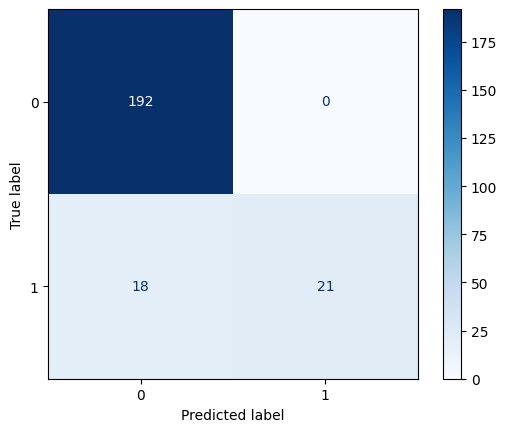

0.7000000000000001

In [ ]:
train_blstm(total_length, text_words_mean, X_train, y_train)